In [1]:
# Base Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
# Feature engineering imports
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

In [102]:
# Model selection imports
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, \
                                    cross_val_score, GridSearchCV, RandomizedSearchCV

In [98]:
# Algorithm imports
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [66]:
# Metrics imports
from sklearn.metrics import mean_squared_error

In [3]:
# Global variables
HOUSING_PATH = "datasets/housing/"

In [4]:
# Plot settings
%matplotlib inline
sns.axes_style()
sns.set(rc={"figure.figsize": (12, 6)})
sns.set_palette("gray")
sns.set_style('white', {'grid.color' : '1.0'})

In [5]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()

In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There is only one categorical variable - `ocean_proximity`. We can tabulate it to see the class distribution

In [9]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025B592AAC88>,
      dtype=object)

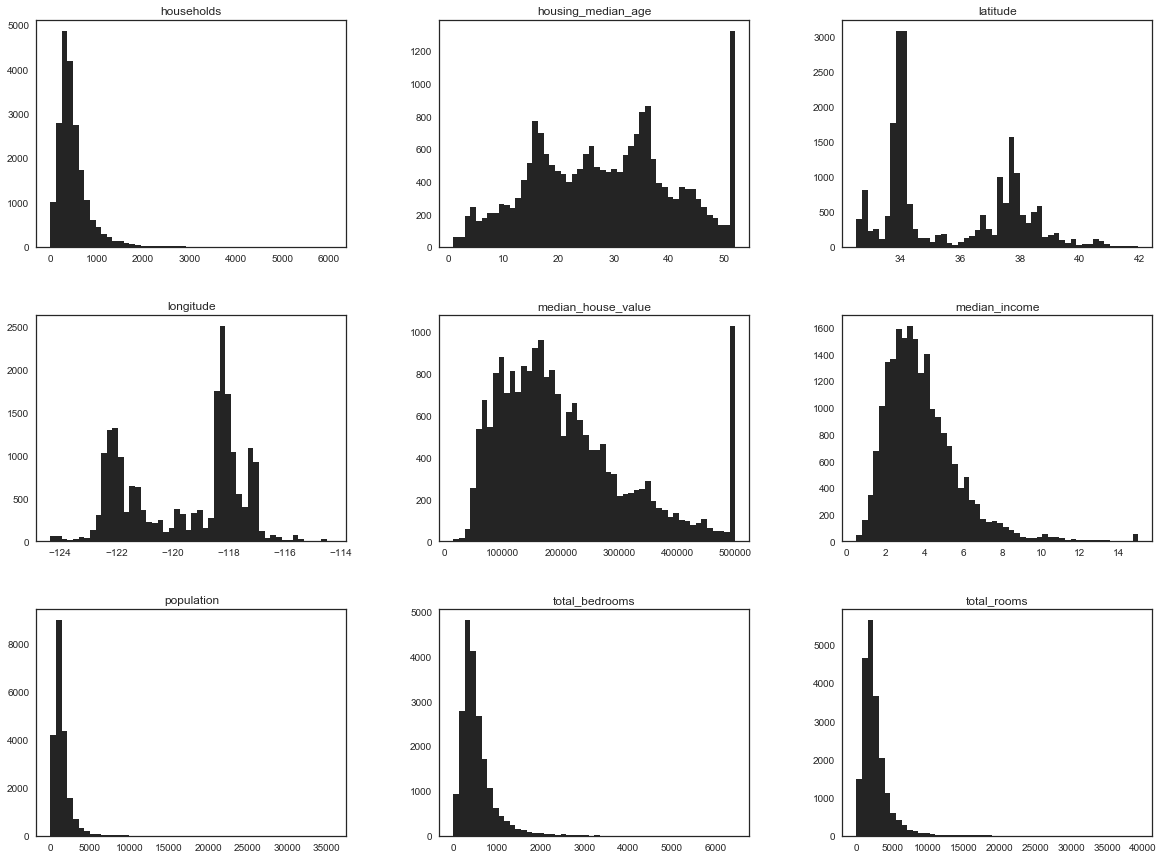

In [10]:
housing.hist(bins = 50, figsize = (20, 15))

In [11]:
housing_train, housing_test = train_test_split(housing, test_size = 0.2, random_state = 20130810)

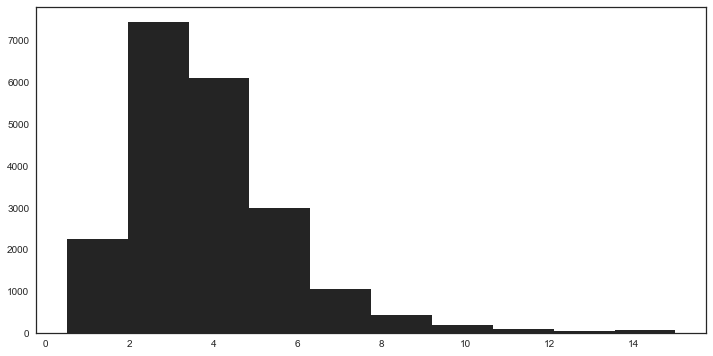

In [12]:
housing['median_income'].hist(bins = 10)

In [13]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5)

# .where method implements the if-then condition; if the condition is true its value is used otherwise
# the specified value is used

housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [14]:
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

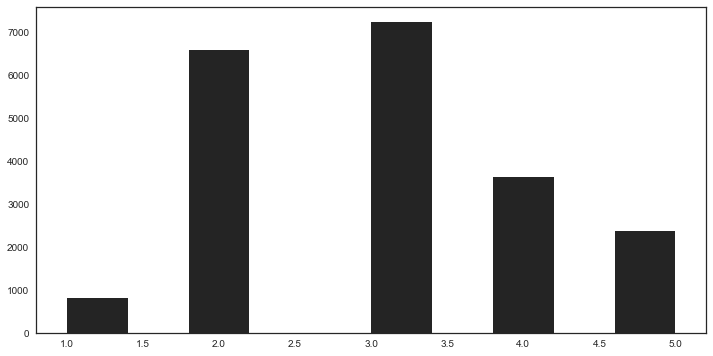

In [15]:
housing['income_cat'].hist()

In [16]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 20130810)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    housing_train_strat = housing.loc[train_index]
    housing_test_strat = housing.loc[test_index]

In [17]:
for set in (housing_train_strat, housing_test_strat):
    set.drop(['income_cat'], axis=1, inplace=True)

It is a good idea to make a copy of the training set to explore. This way additional variables can be added and modified as the exploration proceeds without disturbing the original training set.

In [18]:
housing = housing_train_strat.copy() 

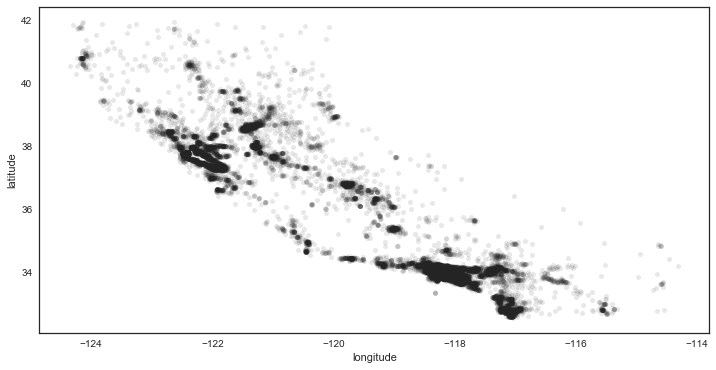

In [19]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1) # avoids overplotting

The above plot shows that there are certain regions where the housing is concentrated

In [20]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690632
total_rooms           0.137324
housing_median_age    0.100658
households            0.066840
total_bedrooms        0.051733
population           -0.022957
longitude            -0.042467
latitude             -0.145586
Name: median_house_value, dtype: float64

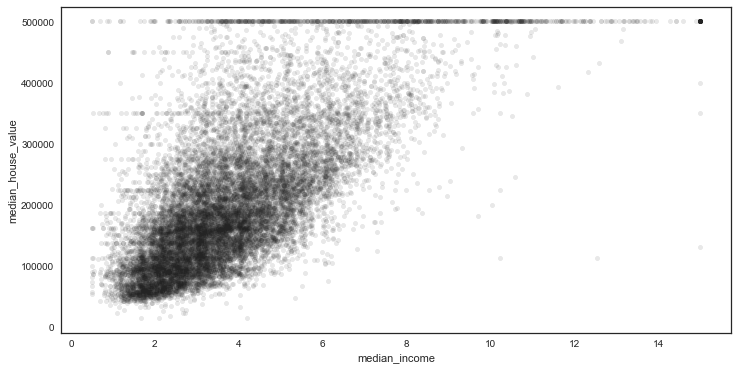

In [21]:
housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)

In [22]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [23]:
housing.corr()['median_house_value'].sort_values(ascending=True)

bedrooms_per_room          -0.255603
latitude                   -0.145586
longitude                  -0.042467
population_per_household   -0.032092
population                 -0.022957
total_bedrooms              0.051733
households                  0.066840
housing_median_age          0.100658
total_rooms                 0.137324
rooms_per_household         0.151704
median_income               0.690632
median_house_value          1.000000
Name: median_house_value, dtype: float64

Feature engineering time... Once again make copies of features and labels and continue to beat the data into an easily ingestible shape

In [64]:
housing = housing_train_strat.drop('median_house_value', axis = 1)
housing_labels = housing_train_strat["median_house_value"].copy()

Missing value imputation; always save imputer state so that it can be used with the test set. This is a general principle, test set should be beaten to shape using the statistics from the train set. This avoids data leakage and inflation of performance

In [25]:
# options for imputation

# housing.dropna(subset=['total_bedrooms'])

# housing.drop('total_bedroos', axis = 1)

median = housing.total_bedrooms.median()
housing.total_bedrooms.fillna(median)

16364     158.0
10686     740.0
10969     851.0
9630      371.0
3320       49.0
5657      280.0
13677    1108.0
9733      654.0
3929      370.0
12248     903.0
13674     395.0
11905     322.0
9967      516.0
1010     3493.0
16333     291.0
101      1603.0
15414     337.0
5812       74.0
10614     388.0
4628     1269.0
6212      469.0
3224      535.0
17979     168.0
303       236.0
9358      400.0
3283      467.0
13018     607.0
1076     1355.0
14719     436.0
1469      854.0
          ...  
15642     486.0
1914      282.0
3527      538.0
7432      408.0
15589      74.0
4005      647.0
4973      417.0
12957    2372.0
12599     281.0
10579     372.0
4975      725.0
6668      483.0
14862     985.0
15565     390.0
16506     220.0
14304     332.0
18378     365.0
9380      409.0
18411     238.0
13209     409.0
8291      785.0
20571     834.0
10012     397.0
13936     633.0
14081     464.0
20042     158.0
9758      311.0
15202     228.0
16715     673.0
15896     340.0
Name: total_bedrooms, Le

Of course scikit learn makes this process formal and neat by providing an `Imputer` class

In [26]:
imputer = Imputer(strategy='median')

In [27]:
housing_num = housing.drop('ocean_proximity', axis = 1) # take out the solo categorical variable

In [28]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

The above operation simply computed the median and stored the result. The imputation is not applied to the data

In [29]:
imputer.statistics_ == housing_num.median().values

array([ True,  True,  True,  True,  True,  True,  True,  True])

Now, we can apply the transformation to the data.

In [30]:
X = imputer.transform(housing_num)

In [31]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

Encoders can be used to trannsform categorical data in a neat way. 

First, if the case is that the levels of a categorical variable are ordered and the distance between the levels is meaningful then the normal encoder will work like a charm

In [32]:
encoder = LabelEncoder()

In [33]:
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([1, 0, 0, ..., 0, 0, 3], dtype=int64)

In [34]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


Mostly however, the difference in the levels of a categorical variable is not meaningful, in which case it is better to go for one hot encoding. To allow `numpy` to figure out the number of rows on its own, we can use -1. The same works in case we want `numpy` to figure out the number of columns as well in other cases. 

In [35]:
encoder = OneHotEncoder()
housing_cat_1h = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1h

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The full process of going from text labels to one-hot encoding can be accomplished by using the `LabelBinarizer` class

In [36]:
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

Another often repeated task is scaling features so that all of them are within roughly the same range. Instead of repeating this task we can build a pipeline object to handle the successive feature transformations

In [38]:
num_pipeline = Pipeline([('imputer', Imputer(strategy='median')),
                         ('std_scaler', StandardScaler())])

In [39]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

Transformation of categorical and numeric features can also be done in a single processing pipeline

In [41]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

In [52]:
num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
                         ('imputer', Imputer(strategy = 'median')),
                         ('std_scaler', StandardScaler())])

In [59]:
# alternative way to create a pipeline

num_pipeline = make_pipeline(DataFrameSelector(num_attribs),
                             Imputer(strategy = 'median'),
                             StandardScaler())

In [53]:
cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)),
                         ('label_binarizer', LabelBinarizerPipelineFriendly())])

In [54]:
full_pipeline = FeatureUnion(transformer_list = [('num_pipeline', num_pipeline),
                                                 ('cat_pipeline', cat_pipeline)])

In [55]:
housing_prepared = full_pipeline.fit_transform(housing)

In [57]:
housing_prepared.shape

(16512, 13)

We begin by fitting a succession of models on the trial data

In [61]:
lin_reg = LinearRegression()

In [65]:
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [68]:
housing_preds = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_preds)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68717.99591023293


In [70]:
tree_reg = DecisionTreeRegressor()

In [71]:
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [72]:
housing_preds = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_preds)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [79]:
rf_reg = RandomForestRegressor()

In [80]:
rf_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [81]:
housing_preds = rf_reg.predict(housing_prepared)
rf_mse = mean_squared_error(housing_labels, housing_preds)
rf_rmse = np.sqrt(rf_mse)
print(rf_rmse)

21834.087585984194


In [99]:
svm_reg = SVR()

In [100]:
svm_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [101]:
housing_preds = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_preds)
svm_rmse = np.sqrt(svm_mse)
print(svm_rmse)

118176.42135103783


In [76]:
scores = cross_val_score(tree_reg, 
                         housing_prepared, 
                         housing_labels, 
                         scoring = 'neg_mean_squared_error',
                         cv = 10)

rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean(), rmse_scores.std())

68460.39322160435 2617.7001423396573


In [77]:
scores = cross_val_score(lin_reg, 
                         housing_prepared, 
                         housing_labels, 
                         scoring = 'neg_mean_squared_error',
                         cv = 10)

rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean(), rmse_scores.std())

68882.83890102625 1672.8019820354011


In [82]:
scores = cross_val_score(rf_reg, 
                         housing_prepared, 
                         housing_labels, 
                         scoring = 'neg_mean_squared_error',
                         cv = 10)

rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean(), rmse_scores.std())

51518.55271133101 1521.7485919894707


At this point the idea is to try out several models at their default settings to get an idea of how they do and shortlist a small number of candidate models

In [83]:
from sklearn.externals import joblib
joblib.dump(rf_reg, 'rf_reg.pkl')
#joblib.load('rf_reg.pkl')

['rf_reg.pkl']

One more job that cross validation does is to help tume hyperparameters

In [89]:
param_grid = [{'n_estimators' : [3, 10, 30],
               'max_features' : [2, 4, 6, 8],
               'bootstrap' : [False]}]

In [90]:
rf_reg = RandomForestRegressor()

In [91]:
grid_search = GridSearchCV(rf_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

In [92]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [93]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 30}

In [94]:
final_model = grid_search.best_estimator_

In [95]:
x_test = housing_test_strat.drop('median_house_value', axis = 1)
y_test = housing_test_strat['median_house_value'].copy()

In [96]:
x_test_prepared = full_pipeline.transform(x_test)

In [97]:
final_predictions = final_model.predict(x_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

48556.75844842883
